In [1]:
import gym, gym_unbalanced_disk, time
import numpy as np
from stable_baselines3 import PPO, SAC
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from stable_baselines3.common.policies import MlpLstmPolicy

In [2]:
def normalise_angle(theta):
    return ((theta)%(2*np.pi))-np.pi

In [3]:
def compute_reward(self):
    q = normalise_angle(self.th)
    theta=self.th
    omega = self.omega
    u = self.u

    r=-q**2-0.1*omega**2-0.001*u**2
    return r

In [4]:
target_angle=np.pi
angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*((self.u)**2)
incorrectAngle_penalty = lambda self: -0.01*np.abs(self.th-target_angle)

reward_function = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self) + incorrectAngle_penalty(self)

In [5]:
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.,reward_fun=reward_function, noise_scale=np.pi) 

model = PPO('MlpPolicy', env, verbose=1, ) #b)
# model = SAC('MlpPolicy', env, verbose=2, learning_starts=1000) #b)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
model.learn(total_timesteps=200_000, )

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | -8.84    |
| time/              |          |
|    fps             | 146      |
|    iterations      | 1        |
|    time_elapsed    | 14       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | -8.24        |
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 2            |
|    time_elapsed         | 27           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0051254015 |
|    clip_fraction        | 0.0393       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -3.06        |
|    learning_r

In [12]:
env.close()
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.,reward_fun=compute_reward,noise_scale=np.pi) 
render_sim = True
obs = env.reset()
u_list=[]
thetas=[]
omegas=[]
rewards=[]
try:
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if render_sim:
            env.render()
        u_list.append(action)
        thetas.append(obs[0])
        omegas.append(obs[1])
        rewards.append(reward)
        if render_sim:
            time.sleep(1/50)
        if done:
            obs=env.reset()
finally:
    env.close()

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 

In [13]:
def get_color(q):
    if abs(q) > 2 * np.pi / 3:  # lower 120
        c=0
    elif abs(q) > np.pi / 3:  # either side
        c=1
    else:  # top
        c=2
    return c

def compute_reward_sim(self):
    q = normalise_angle(self.th)
    r=compute_reward(self)
    c=get_color(q)
    return q, r, c

In [14]:
@dataclass
class Data:
    th = None
    omega = None
    u = None

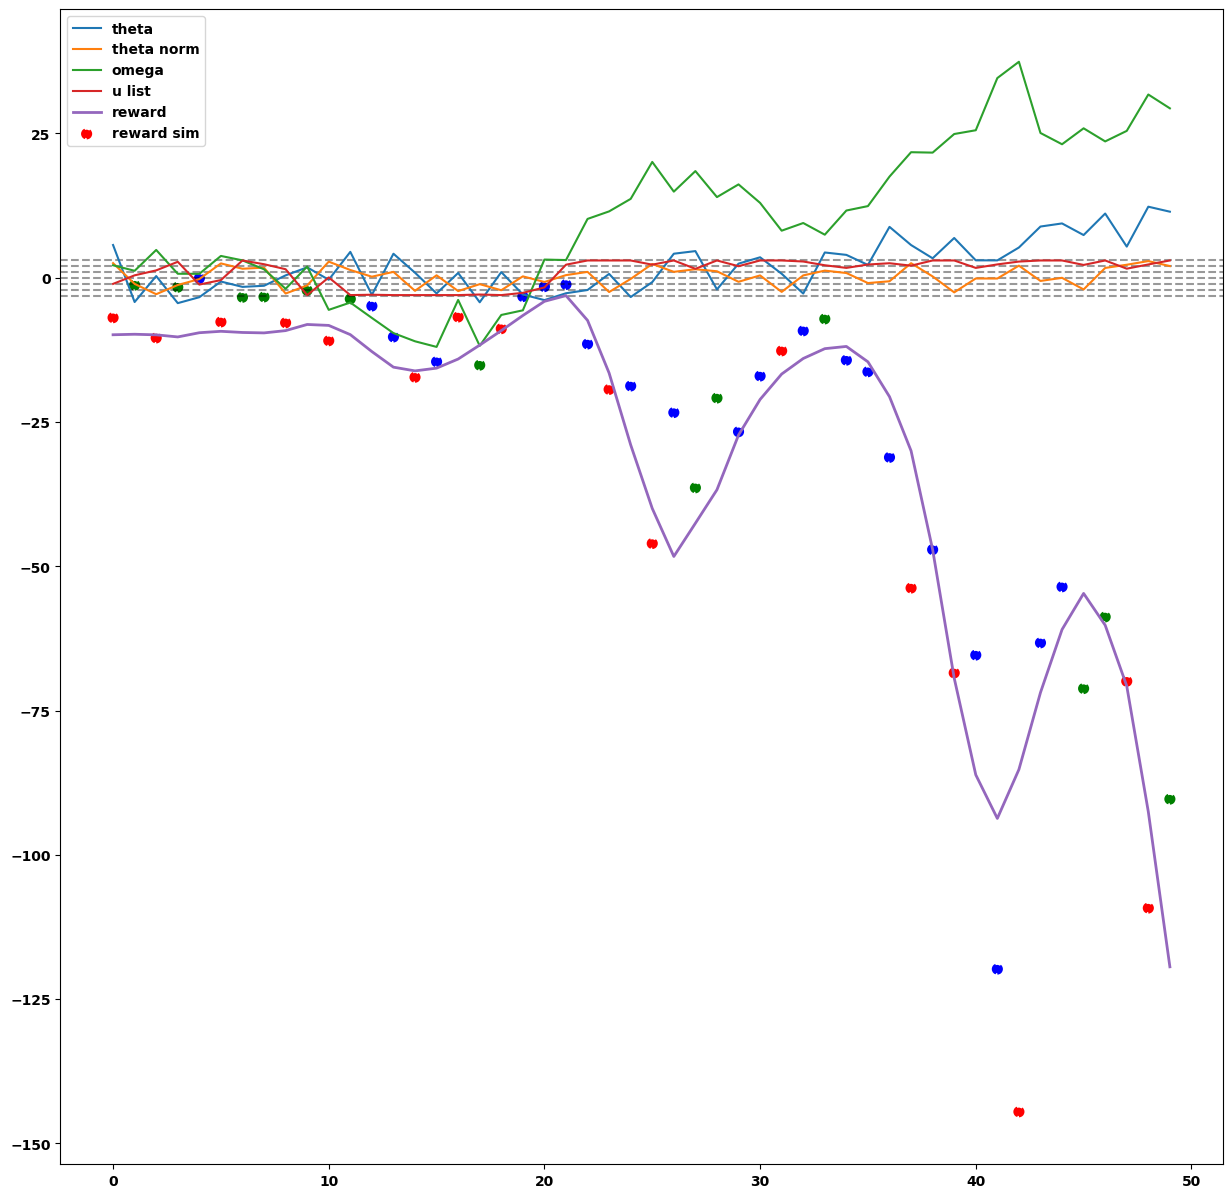

In [15]:
rewards_sim=[]
colors=[]
thetas_norm=[]
colormap = np.array(['r', 'g', 'b'])
for i in range(len(u_list)):
    data=Data()
    data.th=thetas[i]
    data.omega=omegas[i]
    data.u=u_list[i]
    q, r,c = compute_reward_sim(data, )
    rewards_sim.append(r)
    colors.append(c)
    thetas_norm.append(q)

rewards_sim=np.array(rewards_sim)
rewards_sim=rewards_sim
colormap = np.array(['r', 'g', 'b'])


plot_start=0#np.argmax(rewards)
plot_end=plot_start+50

plt.figure(figsize=(15,15))
[plt.axhline(x, ls='--',c='black',alpha=0.4) for x in np.arange(-1,1.1,1/3)*np.pi]

plt.plot(thetas[plot_start:plot_end], label='theta')
plt.plot(thetas_norm[plot_start:plot_end], label='theta norm')
plt.plot(omegas[plot_start:plot_end], label='omega')
# plt.plot(np.array(omegas[:plot_end])**2, label='omega^2')
plt.plot(u_list[plot_start:plot_end], label='u list')
plt.plot(rewards[plot_start:plot_end], linewidth=2, label='reward')
plt.scatter([*range(len(u_list[plot_start:plot_end]))], rewards_sim[plot_start:plot_end], ls='--', linewidth=2, label='reward sim', c=colormap[colors[plot_start:plot_end]])
plt.legend()
plt.show()

In [16]:
# obs = env.reset()
# thetas=[]
# windup_time=15
# us=np.array([3]*windup_time + [-3]*(1000-windup_time))*(-1)
# try:
#     for i in range(1000):
#         obs, reward, done, info = env.step(us[i])
#         thetas.append(obs[0])
#         env.render()
#         time.sleep(1/50)
#         if done:
#             env.reset()
# finally:
#     env.close()
